In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

In [ ]:
# izbrali si bomo 3 visine, zato da bomo lahko boljše analizirali v treh območjih
def analiziraj_podatke_popolno(ime_datoteke, visina1=0.4, visina2=0.35, visina3=0.4):
    # 1. Naložimo podatke
    podatki = np.load(ime_datoteke)
    cas = podatki['Time (s)']
    signal = podatki['Input 1 (V)']

    fs = 1000  # Hz
    nizka = 0.5
    visoka = 40

    def maslopasovni_filter(nizka, visoka, fs, red=4): #Butterworth filter - to je še najboljši prevod
        nyq = 0.5 * fs
        nizka_norm = nizka / nyq
        visoka_norm = visoka / nyq
        b, a = butter(red, [nizka_norm, visoka_norm], btype='band')
        return b, a

    def uporabi_filter(podatki, nizka, visoka, fs, red=4):
        b, a = maslopasovni_filter(nizka, visoka, fs, red=red)
        filtriran = filtfilt(b, a, podatki)
        return filtriran

    def analiza_vrhov(vrhovi, casovni_segment):
        cas_vrhov = casovni_segment[vrhovi]
        RR_intervali = np.diff(cas_vrhov)
        if len(RR_intervali) > 0:
            povp_RR = np.mean(RR_intervali)
            HR = 60 / povp_RR
            HRV = np.std(RR_intervali)
        else:
            HR = np.nan
            HRV = np.nan
        return HR, HRV

    # 1. Izrišemo raw signal - nepotrebno, ampak za preglednost
    plt.figure(figsize=(12,6))
    plt.plot(cas, signal, label='Originalni signal', alpha=0.7)
    plt.xlabel('Čas [s]')
    plt.ylabel('Amplituda [V]')
    plt.legend()
    plt.title(f'Originalni signal: {ime_datoteke}')
    plt.grid()
    plt.show()

    # 2. Analiza vsakega obdobja
    rezultati = []
    for (zacetek, konec, prag) in [(0, 120, visina1), (120, 180, visina2), (180, 300, visina3)]:
        maska = (cas >= zacetek) & (cas <= konec)
        cas_segment = cas[maska]
        signal_segment = signal[maska]

        filtriran = uporabi_filter(signal_segment, nizka, visoka, fs)
        vrhovi, lastnosti = find_peaks(filtriran, height=prag, distance=fs*0.3)

        HR, HRV = analiza_vrhov(vrhovi, cas_segment)
        
        rezultati.append((HR, HRV))

        # Izrišemo signal s filtrom in vrhovi
        plt.figure(figsize=(10,5))
        plt.plot(cas_segment, filtriran, label=f'Filtriran signal {zacetek}-{konec} s')
        plt.plot(cas_segment[vrhovi], filtriran[vrhovi], 'rx', label='R-vrhi')
        plt.xlabel('Čas [s]')
        plt.ylabel('Amplituda [V]')
        plt.legend()
        plt.title(f'Detekcija R-vrhov: {zacetek}-{konec} sekund')
        plt.grid()
        plt.show()

    # 3. Izpišemo rezultate
    print(f'\nRezultati za {ime_datoteke}:')
    obdobja = ['0–120 s (normalno)', '120–180 s (hiperventilacija)', '180–300 s (okrevanje)']
    for idx, (HR, HRV) in enumerate(rezultati):
        print(f'{obdobja[idx]}: HR = {HR:.2f} bpm, HRV = {HRV:.4f} s')

    return rezultati


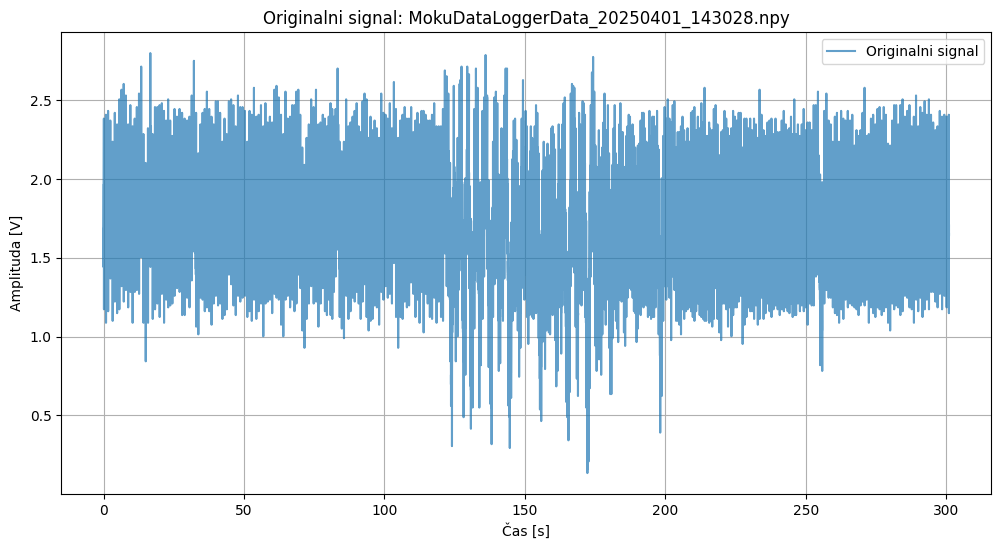

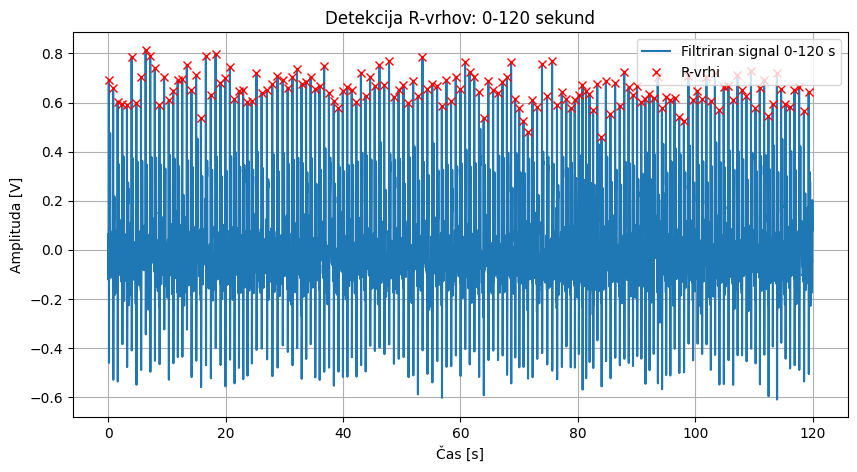

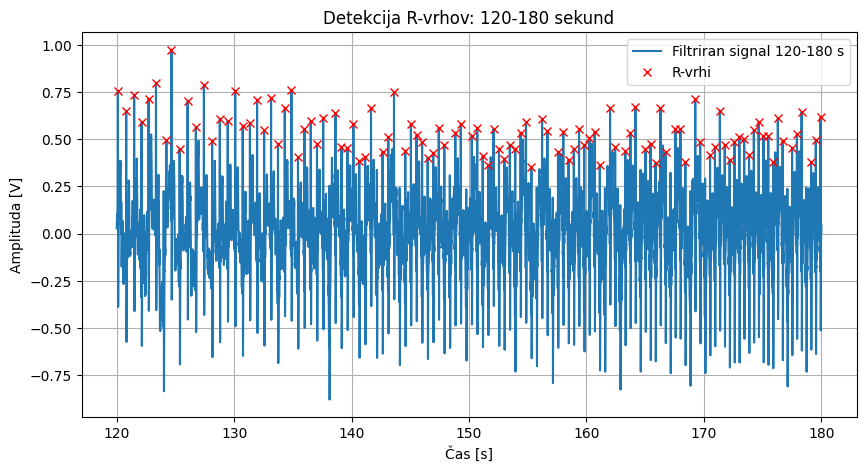

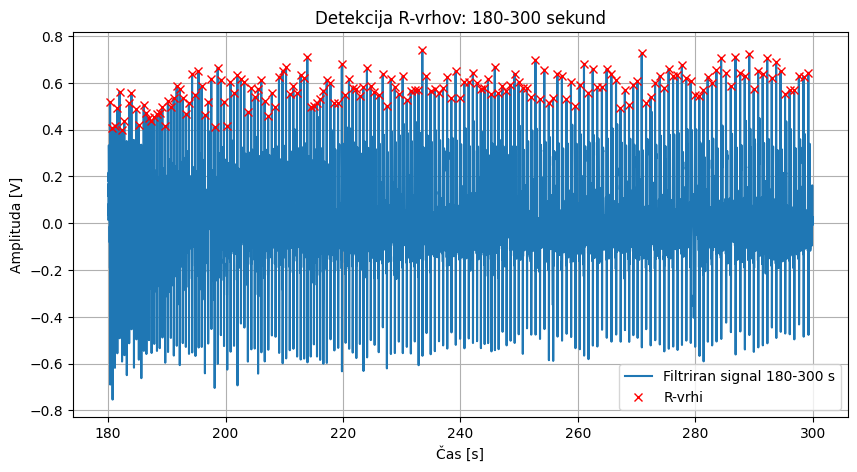


Rezultati za MokuDataLoggerData_20250401_143028.npy:
0–120 s (normalno): HR = 77.52 bpm, HRV = 0.0509 s
120–180 s (hiperventilacija): HR = 108.29 bpm, HRV = 0.1657 s
180–300 s (okrevanje): HR = 91.82 bpm, HRV = 0.1114 s


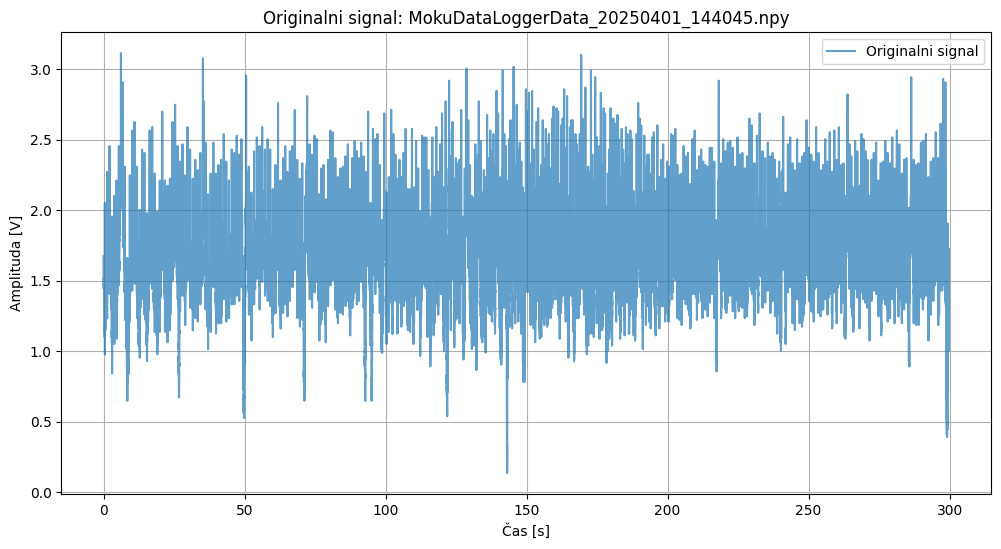

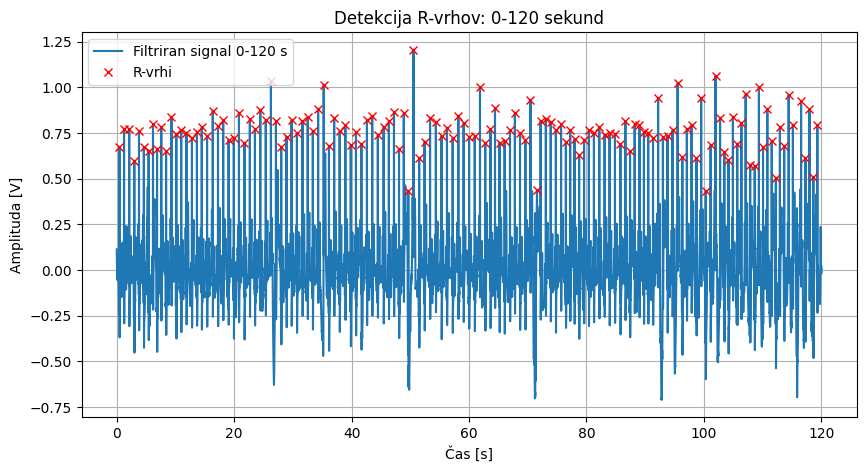

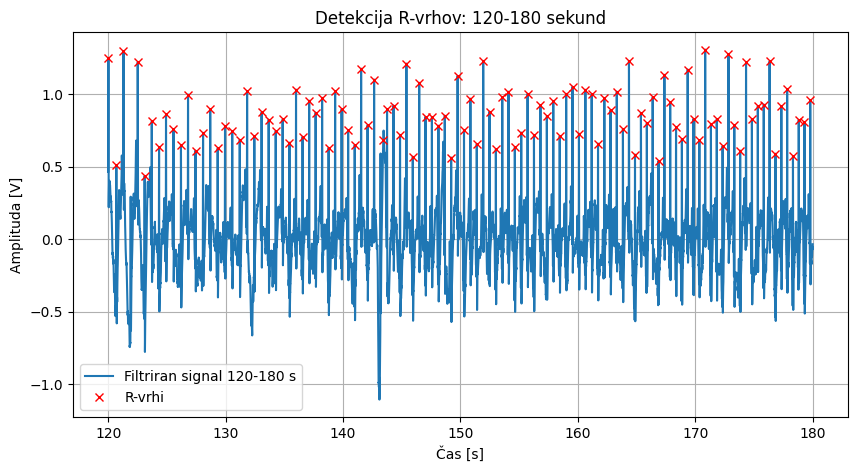

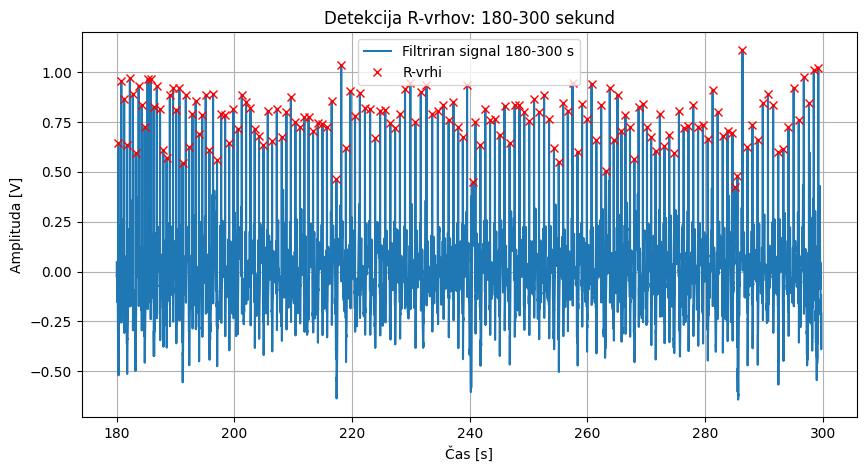


Rezultati za MokuDataLoggerData_20250401_144045.npy:
0–120 s (normalno): HR = 70.67 bpm, HRV = 0.0962 s
120–180 s (hiperventilacija): HR = 108.42 bpm, HRV = 0.0834 s
180–300 s (okrevanje): HR = 80.17 bpm, HRV = 0.1292 s


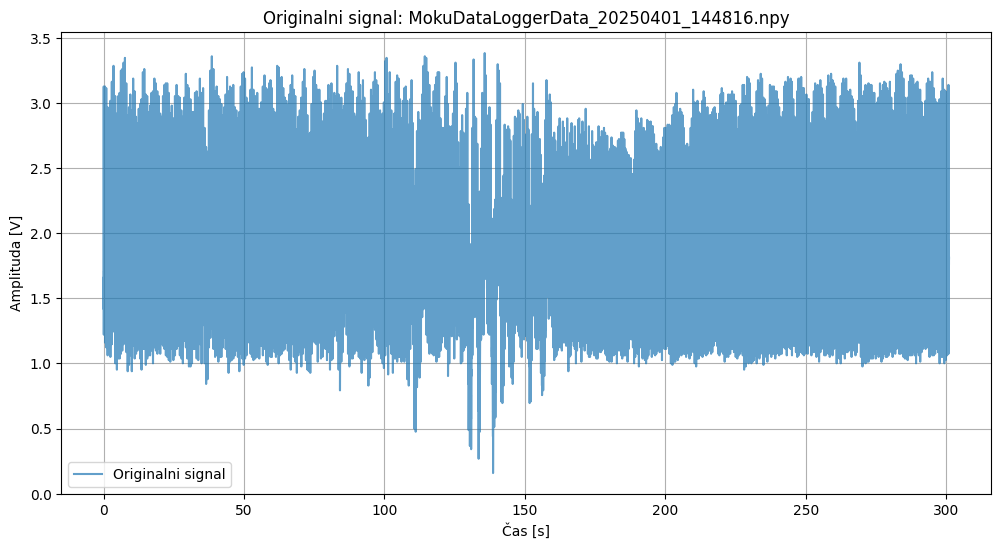

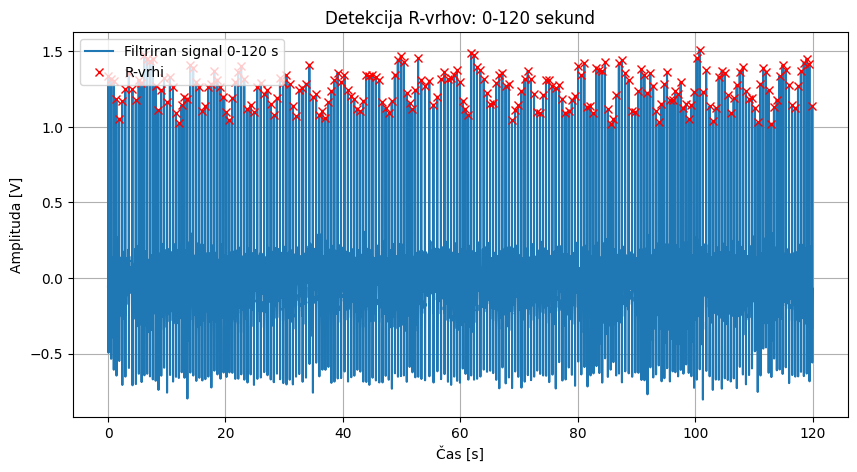

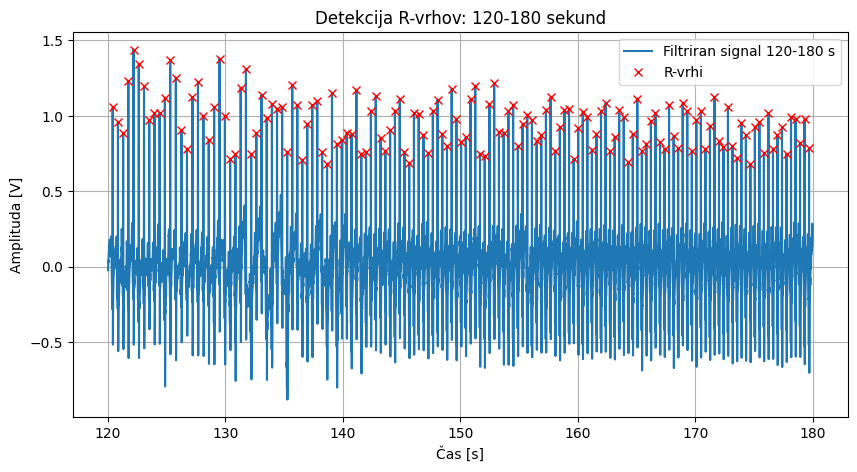

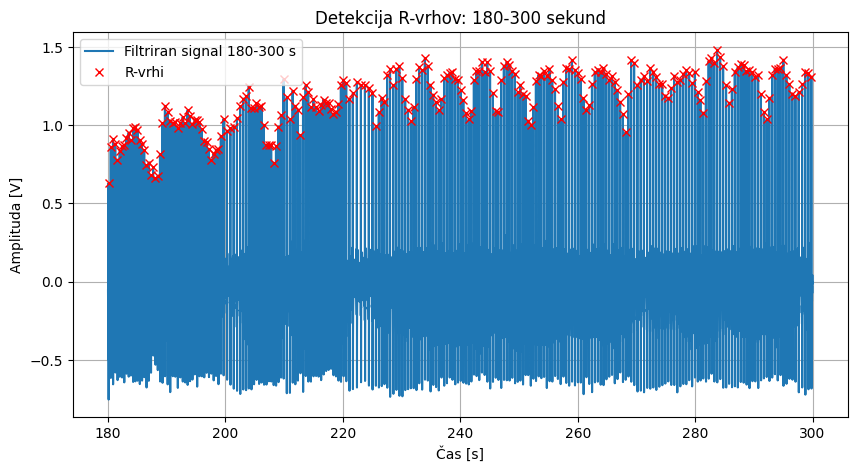


Rezultati za MokuDataLoggerData_20250401_144816.npy:
0–120 s (normalno): HR = 115.63 bpm, HRV = 0.0424 s
120–180 s (hiperventilacija): HR = 146.69 bpm, HRV = 0.0257 s
180–300 s (okrevanje): HR = 128.31 bpm, HRV = 0.0540 s


In [ ]:
# Pokličemo funkcijo za analizo podatkov iz treh datotek
rezultati1 = analiziraj_podatke_popolno('MokuDataLoggerData_20250401_143028.npy')
rezultati2 = analiziraj_podatke_popolno('MokuDataLoggerData_20250401_144045.npy')
rezultati3 = analiziraj_podatke_popolno('MokuDataLoggerData_20250401_144816.npy')



Zadnji 4 del naloge nima smisla saj imamo samo tri signale za analizirati. Da pa Wilcoxon-ov test deluje pravilno pa potrebujemo več podatkov!!